In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from bs4 import BeautifulSoup
from urllib.request import urlopen
import sqlite3
import itertools
from pprint import pprint
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#I did not realize the airport data was provided but found airport lat/long data elsewhere
#I have included the .csv file in the repo
#please check that the path to .csv file containing 
#lat/long of us airports matches the path on the machine

LatLong_path = '/Users/danslaughter/Downloads/Airport_Codes_mapped_to_Latitude_Longitude_in_the_United_States.csv'
LatLong_DF = pd.read_csv(LatLong_path, index_col = 0, parse_dates = [0])

In [3]:
#I did not realize the airport data was provided but found the 50 busy airports data elsewhere
#URL is a webpage (wiki) containing two tables with info on 50 busy airports in the USA
#we use urllib to open URL and read in html

URL = 'https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States'
response = urlopen(URL)
html = response.read()
response.close()

In [4]:
#we use BeautifulSoup4 to scrape the table from the html
soup = BeautifulSoup(html,"html.parser")

#first we scrape table 1's rows, the table has 31 rows, we want the last 30
#table 1 contains busy airports 1-30
#grab first five pieces of data from each row (rank, name, IATA code, city served, state)
table1_rows = []
for index in range(1,31):
    table1_rows.append([x.get_text() for x in soup.findAll("table")[0].findAll('tr')[index].findAll('td')[:5]])

#next we scrape table 2's rows, the table has 31 rows, we want the first 20 (excluding first row)
#table 2 contains busy airports 31-60
#grab first five pieces of data from each row (rank, name, IATA code, city served, state)
table2_rows = []
for index in range(1,21):
    table2_rows.append([x.get_text() for x in soup.findAll("table")[1].findAll('tr')[index].findAll('td')[:5]])

#join together the data from the two tables
#to make list of top 50 busy airports in USA
table_rows = table1_rows + table2_rows

#join in airport lat/long data from .csv file 
for index in range(len(table_rows)):
    table_rows[index].append(LatLong_DF.get_value(table_rows[index][2], col = 'Latitude'))
    table_rows[index].append(LatLong_DF.get_value(table_rows[index][2], col = 'Longitude'))

#package up data into a list of tuples
#this will make pulling data into SQL database easier 
tuples = []
for index in range(len(table_rows)):
    tuples.append(tuple(table_rows[index]))

In [5]:
#generate list of IATA codes for 50 busy airports
airport_IATA = [tuple_[2] for tuple_ in tuples]

#generate list containing unique pairs of all IATA codes
airport_IATA_pairs = sorted(list(itertools.combinations(airport_IATA, 2)))

In [6]:
#here we generate list containing lat distance, long distance, 
#and total (Euclidian) distance between a given airport pair

pairs_lat_long = []
for pair in airport_IATA_pairs:
    for index in range(len(tuples)):
        
        if pair[0] == tuples[index][2]: #retrieve lat/long of 1st airport in pair
            lat_0 = tuples[index][5]
            long_0 = tuples[index][6]
            
        if pair[1] == tuples[index][2]: #retrieve lat/long of 2nd airport in pair
            lat_1 = tuples[index][5]
            long_1 = tuples[index][6]
            
    delta_lat = lat_0 - lat_1 #compute lat dist
    delta_long = long_0 - long_1 #compute long dist
    dist = np.sqrt(pow(delta_lat, 2) + pow(delta_long, 2)) #compute total dist
        
    pairs_lat_long.append([list(pair), delta_lat, delta_long, dist]) #build list of IATA pairs and distances

In [7]:
!rm /tmp/airports.db

#create a SQL db to contain airport data
connection = sqlite3.connect("/tmp/airports.db")

cursor = connection.cursor()

#define a SQL command to create table with our airport info 
sql_cmd = """CREATE TABLE airports (id INTEGER PRIMARY KEY AUTOINCREMENT,
    rank TEXT, name TEXT, IATA TEXT, city_served TEXT, state TEXT, lat FLOAT, long FLOAT)"""

#create SQL table
cursor.execute(sql_cmd)

In [8]:
#insert data into SQL table for each airport in our list of tuples
#achieved by looping over each tuple contained in the list tuples

for airport in tuples:
    sql_cmd = "INSERT INTO airports (rank, name, IATA, city_served, state, lat, long) VALUES " + str(airport)
    cursor.execute(sql_cmd)

#select all data from airport database so we can view it
sql_cmd = "SELECT * FROM airports"  
cursor.execute(sql_cmd)

#fetch all data returned and print out each entry
db_info = cursor.fetchall()
for entry in db_info: 
    print(entry)
    
connection.commit()
connection.close()

(1, '1', 'Hartsfield–Jackson Atlanta International Airport', 'ATL', 'Atlanta', 'GA', 33.6367, 84.4281)
(2, '2', 'Los Angeles International Airport', 'LAX', 'Los Angeles', 'CA', 33.9425, 118.4072)
(3, '3', "O'Hare International Airport", 'ORD', 'Chicago', 'IL', 41.9808, 87.9067)
(4, '4', 'Dallas/Fort Worth International Airport', 'DFW', 'Dallas/Fort Worth', 'TX', 32.8969, 97.0381)
(5, '5', 'John F. Kennedy International Airport', 'JFK', 'New York', 'NY', 40.6397, 73.7789)
(6, '6', 'Denver International Airport', 'DEN', 'Denver', 'CO', 39.8617, 104.6731)
(7, '7', 'San Francisco International Airport', 'SFO', 'San Francisco', 'CA', 37.6189, 122.375)
(8, '8', 'McCarran International Airport', 'LAS', 'Las Vegas', 'NV', 36.08, 115.1522)
(9, '9', 'Charlotte Douglas International Airport', 'CLT', 'Charlotte', 'NC', 35.2139, 80.9431)
(10, '10', 'Seattle–Tacoma International Airport', 'SEA', 'Seattle/Tacoma', 'WA', 47.45, 122.3117)
(11, '11', 'Phoenix Sky Harbor International Airport', 'PHX', 'P

In [9]:
#create a list of pairs of years to be used in constructing wunderground urls that will be pinged
year_pairs = [['2009', '2010'], ['2010', '2011'], ['2011', '2012'], ['2012', '2013'], ['2013', '2014'], 
              ['2014', '2015'], ['2015', '2016'], ['2016', '2017'], ['2017', '2018']]

In [10]:
#create a list containing wunderground urls
#each url contains weather data for a given airport across a year (given by year_pairs)
#we pull this data for all 50 airports

weather_year_urls = []
for index1 in range(len(tuples)):
    for index2 in range(len(year_pairs)):
        
        if tuples[index1][2] == 'HNL' or tuples[index1][2] == 'SJU':
            weather_year_urls.append('https://www.wunderground.com/history/airport/' + tuples[index1][2] + '/' 
                                     + year_pairs[index2][0] + '/1/1/CustomHistory.html?dayend=1&monthend=1&yearend=' + 
                                     year_pairs[index2][1])
            
        else: 
            weather_year_urls.append('https://www.wunderground.com/history/airport/K' + tuples[index1][2] + '/' + 
                                     year_pairs[index2][0] + '/1/1/CustomHistory.html?dayend=1&monthend=1&yearend=' + 
                                     year_pairs[index2][1])

In [11]:
#create lists containing months (and their corresponding numeric values)
#the number of days in a month (account for leap years) and the leap years in our year range

months = [['Jan', '1'], ['Feb', '2'], ['Mar', '3'], ['Apr', '4'], ['May', '5'], ['Jun', '6'], 
          ['Jul', '7'], ['Aug', '8'], ['Sep', '9'], ['Oct', '10'], ['Nov', '11'], ['Dec', '12']]
days_in_months = ['31', '28', '31', '30', '31', '30', '31', '31', '30', '31', '30', '31']
days_in_months_leap = ['31', '29', '31', '30', '31', '30', '31', '31', '30', '31', '30', '31']
leap_years = ['2012', '2016']

In [12]:
#create lists containing the cumulative sum for days_in_months and days_in_months_leap
#this is for convenience and will make indexing easier later

days_in_months_int = [int(x) for x in days_in_months]
days_in_months_int = [0] + days_in_months_int
cumulative_days = np.cumsum(days_in_months_int)

days_in_months_int_leap = [int(x) for x in days_in_months_leap]
days_in_months_int_leap = [0] + days_in_months_int_leap
cumulative_days_leap = np.cumsum(days_in_months_int_leap)

In [ ]:
########### NOTE ###########
#this cell takes ~20 minutes to run - avoid rerunning it
#since it takes so long, we have saved the data
#and it can be loaded in (see airport_weather.npy)

weather_data = []

for index in range(len(weather_year_urls)):

    #URL is a webpage containing annual weather data from a given airport
    #use urllib to open URL and read in html
    URL = weather_year_urls[index]
    response = urlopen(URL)
    html = response.read()
    response.close()
    
    #pull airport IATA code and year from the URL itself
    #Honolulu and San Jaun's URLS are slightly different than the rest
    if 'HNL' in weather_year_urls[index][42:52] or 'SJU' in weather_year_urls[index][42:52]:
        airport = weather_year_urls[index][45:48]
        year = weather_year_urls[index][49:53]
    else:
        airport = weather_year_urls[index][46:49]
        year = weather_year_urls[index][50:54]
    
    #use BeautifulSoup4 to scrape the table from the html
    soup = BeautifulSoup(html,"html.parser")
    
    #scrape all data from the table in URL
    temp_rows = [x.get_text().replace('\n', ' ').replace('\t', '').replace('\xa0', '') 
                 for x in soup.findAll('table')[1].findAll('td')]
    
    #format the data from the table
    #we replace any entries that contain text (effectively removing the 'events' column) with empty strings, 
    #while ignoring ' T ' which often appears in the precip column (which we want to keep)
    for index1 in range(len(temp_rows)):
        if any(char.isalpha() for char in temp_rows[index1]) and temp_rows[index1] != ' T ':
            temp_rows[index1] = ''
            
    #format the data from the table
    #we now remove all empty strings
    temp_rows = [x for x in temp_rows if x != '' and x != '  ']
    
    #now retrieve relevant data (day, high(low) temp, humidity, precip) from table data
    #populate a list of lists with this data for each airport 
    reduced_rows = []
    for index in range(int(len(temp_rows)/20)):
        reduced_rows.append([temp_rows[index*20], year, airport, temp_rows[index*20 + 1], 
                                  temp_rows[index*20 + 3], temp_rows[index*20 + 8], 
                                  temp_rows[index*20 + 19]])

    #next insert the corresponding month into each list in reduced_rows
    #watch out for leap years!
    if year == leap_years[0] or year == leap_years[1]:
        for index1 in range(len(months)):
            for index2 in range(int(days_in_months_leap[index1])):
                #reduced_rows[cumulative_days_leap[index1] + index2].append(months[index1])
                reduced_rows[cumulative_days_leap[index1] + index2].insert(0, months[index1][1])

    else: 
        for index1 in range(len(months)):
            for index2 in range(int(days_in_months[index1])):
                #reduced_rows[cumulative_days[index1] + index2].append(months[index1])
                reduced_rows[cumulative_days[index1] + index2].insert(0, months[index1][1])
    
    #create a nicely formatted date from day, month, year
    #add this data to our list of relevant data (reduced_rows)
    for index in range(len(reduced_rows)):
        if len(reduced_rows[index][1]) < 2 and len(reduced_rows[index][0]) < 2:
            reduced_rows[index].insert(0, '0' + reduced_rows[index][0] + '/0' + reduced_rows[index][1] + 
                                       '/' + reduced_rows[index][2])
        elif len(reduced_rows[index][1]) < 2:
            reduced_rows[index].insert(0, reduced_rows[index][0] + '/0' + reduced_rows[index][1] + 
                                       '/' + reduced_rows[index][2])
        elif len(reduced_rows[index][0]) < 2:
            reduced_rows[index].insert(0, '0' + reduced_rows[index][0] + '/' + reduced_rows[index][1] + 
                                       '/' + reduced_rows[index][2])
        else:
            reduced_rows[index].insert(0, reduced_rows[index][0] + '/' + reduced_rows[index][1] + 
                                       '/' + reduced_rows[index][2])
    
    #convert each list with airport, date and weather information into a tuple for SQL
    for index in range(len(reduced_rows)):
        weather_data.append(tuple(reduced_rows[index]))

#np.save('/Users/danslaughter/Desktop/airport_weather_1.npy', weather_data)

In [13]:
########### NOTE ###########
#here we read in the historical weather data from all airports we scraped above
#we do not need to re-scrape the data every time since it is saved

weather_data_pre_fix = np.load('/Users/danslaughter/Desktop/airport_weather.npy')

#load the data as tuples using list comprehension
#SQL likes tuples
weather_data_fix = [tuple(stuff) for stuff in weather_data_pre_fix]

In [14]:
#prepare a generic SQL query string where we use format to 
#grab weather data (high temp, precip) from all pairs of airports

query = "SELECT date, high_temp, precip, IATA FROM weather WHERE IATA = '{}' OR IATA = '{}'"
queries = [query.format(IATA_1,IATA_2) for IATA_1, IATA_2 in airport_IATA_pairs]

In [15]:
!rm /tmp/weather.db

#create a SQL db to contain weather data
connection = sqlite3.connect("/tmp/weather.db")

cursor = connection.cursor()

#define a SQL command to create table with our airport weather data 
sql_cmd = """CREATE TABLE weather (id INTEGER PRIMARY KEY AUTOINCREMENT,
    date DATE, month TEXT, day TEXT, year TEXT, IATA TEXT, high_temp TEXT, low_temp TEXT, humidity TEXT, precip TEXT)"""

#create SQL table
cursor.execute(sql_cmd)

In [16]:
#insert data into SQL table for each airport pair
#achieved by looping over each tuple contained in the weather data we loaded in

for weather in weather_data_fix:
    sql_cmd = "INSERT INTO weather (date, month, day, year, IATA, high_temp, low_temp, humidity, precip) VALUES " + str(weather)
    cursor.execute(sql_cmd)

In [17]:
#this cell takes ~60 seconds to run
#next we determine the correlations between airports by weather (high temp, precip)
#we loop over our list of pre-defined queries that grabs weather data 
#(high temp, precip) from all pairs of airports

pair_corr = []
for query in queries:
    
    sql_cmd = query #grab query
    cursor.execute(sql_cmd) #run query
    db_info = cursor.fetchall() #fetch all data returned

    pair = [db_info[1][3], db_info[-1][3]] #grab the airport pair from the query
    
    temp = [data[1] for data in db_info] #grab temperature data from the query

    #here we cast all temp values to ints
    #if a temp value is ' - ' (some data missing), we grab the adjacent data that isn't ' - '
    #and take the average of these neighbors and replace the missing data with this average
    for index, value in enumerate(temp):
        if value == '   - ':
            try:
                temp[index] = int((int(temp[index + 1]) + int(temp[index - 1]))/2)
            except ValueError:
                try:
                    temp[index] = int((int(temp[index + 2]) + int(temp[index - 1]))/2)
                except ValueError:
                    try:
                        temp[index] = int((int(temp[index + 3]) + int(temp[index - 1]))/2)
                    except ValueError:
                        pass
        else:
            temp[index] = int(temp[index])
    
    temp1 = temp[0:int(len(temp)/2)] #temp data for 1st airport in pair
    temp2 = temp[int(len(temp)/2):len(temp)] #temp data for 2nd airport in pair
    
    #compute Pearson correlation coefficient for temperature data of the pair
    #given a 1 day, 3 day, and 7 day offset
    temp_corr_1 = np.corrcoef(temp1[0 : len(temp1) - 1], temp2[1 : ])[0][1]
    temp_corr_3 = np.corrcoef(temp1[0 : len(temp1) - 3], temp2[3 : ])[0][1]
    temp_corr_7 = np.corrcoef(temp1[0 : len(temp1) - 7], temp2[7 : ])[0][1]

    #grab precip data from the query
    #here we cast the precip values to float and set any ' T ' values to 0.0
    precip = [float(data[2])
              if data[2] != ' T '
              else 0.00 
              for data in db_info]
    
    precip1 = precip[0:int(len(precip)/2)] #precip data for 1st airport in pair
    precip2 = precip[int(len(precip)/2):len(precip)] #precip data for 2nd airport in pair
    
    #compute Pearson correlation coefficient for precipitation data of the pair
    #given a 1 day, 3 day, and 7 day offset    
    precip_corr_1 = np.corrcoef(precip1[0 : len(precip1) - 1], precip2[1 : ])[0][1]
    precip_corr_3 = np.corrcoef(precip1[0 : len(precip1) - 3], precip2[3 : ])[0][1]
    precip_corr_7 = np.corrcoef(precip1[0 : len(precip1) - 7], precip2[7 : ])[0][1]
    
    #build a list containing the temp/precip correlations for a given airport pair
    pair_corr.append([pair, [temp_corr_1, temp_corr_3, temp_corr_7], [precip_corr_1, precip_corr_3, precip_corr_7]])

connection.commit()
connection.close()

In [18]:
#create a list with strings that will pair up with the correlation data 
category = ['temp_1_day', 'temp_3_day', 'temp_7_day', 'precip_1_day', 'precip_3_day', 'precip_7_day']

#create a list of lambda functions that return correlation data from pair_corr
lambdas = [lambda x: abs(x[1][0]), lambda x: abs(x[1][1]), lambda x: abs(x[1][2]), lambda x: abs(x[2][0]), 
          lambda x: abs(x[2][1]), lambda x: abs(x[2][2])]

In [19]:
#create a list of the top ten correlated pairs for each kind in category
top_tens = [sorted(pair_corr, key=lambda_, reverse=True)[:10] for lambda_ in lambdas]

#create a list containing the indicies of the correlation data
indicies = [(index1, index2) for index1 in range(1,3) for index2 in range(3)]

#create two dictionaries that contain indicies by category 
#and top ten correlated pairs by category
dict1 = dict(zip(category, indicies))
dict2 = dict(zip(category, top_tens))

#create a list of dictionaries containing the top ten correlated pairs for a given category
corr_cat = []
for key in dict1:
    index_a, index_b = dict1[key]
    all_vals = [(value[index_a][index_b], value[0]) for value in dict2[key]]
    dict2[key] = all_vals
    d = {'kind' : key, 'values' : all_vals}
    corr_cat.append(d)

#print out the data so we can see the top correlated pairs for all six categories
#and the corresponding Pearson correlation coefficients
pprint(corr_cat)

[{'kind': 'temp_1_day',
  'values': [(0.9509073996983507, ['ORD', 'DTW']),
             (0.94551407028175749, ['LAS', 'PHX']),
             (0.94485884019642008, ['DTW', 'PHL']),
             (0.94324430994971908, ['MSP', 'MDW']),
             (0.94270036271356827, ['MDW', 'CLE']),
             (0.94193480653096751, ['MSP', 'DTW']),
             (0.94170879692254417, ['ORD', 'CLE']),
             (0.94070492295828312, ['DTW', 'LGA']),
             (0.93980304319167574, ['MSP', 'MKE']),
             (0.9396063415831577, ['IND', 'PIT'])]},
 {'kind': 'temp_3_day',
  'values': [(0.8850645611603517, ['MSP', 'DTW']),
             (0.87991799417945449, ['MSP', 'LGA']),
             (0.87689190462719124, ['MSP', 'PHL']),
             (0.87605018687119385, ['LAS', 'SLC']),
             (0.87479557227733629, ['LAS', 'PHX']),
             (0.87079197997456392, ['MSP', 'DCA']),
             (0.8697136829407407, ['MSP', 'MDW']),
             (0.86920398905311036, ['MSP', 'BWI']),
             (0.86

In [20]:
#here we pull data from corr_cat and package it up
#achieved by looping over the data from a given category and inserting
#correlation value, and distances (lat, long, total) into a list

temps_1_day = []
for index1 in range(10):
    for index2 in range(len(pairs_lat_long)):
        if pairs_lat_long[index2][0] == corr_cat[0]['values'][index1][1]:
            temps_1_day.append([corr_cat[0]['values'][index1], pairs_lat_long[index2][1], 
                                pairs_lat_long[index2][2], pairs_lat_long[index2][3]])

temps_3_day = []
for index1 in range(10):
    for index2 in range(len(pairs_lat_long)):
        if pairs_lat_long[index2][0] == corr_cat[1]['values'][index1][1]:
            temps_3_day.append([corr_cat[1]['values'][index1], pairs_lat_long[index2][1], 
                                pairs_lat_long[index2][2], pairs_lat_long[index2][3]])

temps_7_day = []
for index1 in range(10):
    for index2 in range(len(pairs_lat_long)):
        if pairs_lat_long[index2][0] == corr_cat[2]['values'][index1][1]:
            temps_7_day.append([corr_cat[2]['values'][index1], pairs_lat_long[index2][1], 
                                pairs_lat_long[index2][2], pairs_lat_long[index2][3]])

precips_1_day = []
for index1 in range(10):
    for index2 in range(len(pairs_lat_long)):
        if pairs_lat_long[index2][0] == corr_cat[3]['values'][index1][1]:
            precips_1_day.append([corr_cat[3]['values'][index1], pairs_lat_long[index2][1], 
                                pairs_lat_long[index2][2], pairs_lat_long[index2][3]])

precips_3_day = []
for index1 in range(10):
    for index2 in range(len(pairs_lat_long)):
        if pairs_lat_long[index2][0] == corr_cat[4]['values'][index1][1]:
            precips_3_day.append([corr_cat[4]['values'][index1], pairs_lat_long[index2][1], 
                                pairs_lat_long[index2][2], pairs_lat_long[index2][3]])

precips_7_day = []
for index1 in range(10):
    for index2 in range(len(pairs_lat_long)):
        if pairs_lat_long[index2][0] == corr_cat[5]['values'][index1][1]:
            precips_7_day.append([corr_cat[5]['values'][index1], pairs_lat_long[index2][1], 
                                pairs_lat_long[index2][2], pairs_lat_long[index2][3]])  

In [21]:
#here we pull correlation value, distance (total) and longitude distance for plotting
#data pulled from what we packaged up in previous cell

temp_1_corrs = []
dists_1 = []
dists_long_1 = []
for data in temps_1_day:
    temp_1_corrs.append(data[0][0])
    dists_1.append(data[3])
    dists_long_1.append(data[2])

temp_3_corrs = []
dists_3 = []
dists_long_3 = []
for data in temps_3_day:
    temp_3_corrs.append(data[0][0])
    dists_3.append(data[3])
    dists_long_3.append(data[2])
    
temp_7_corrs = []
dists_7 = []
dists_long_7 = []
for data in temps_7_day:
    temp_7_corrs.append(data[0][0])
    dists_7.append(data[3])
    dists_long_7.append(data[2])
    
precip_1_corrs = []
dist_1 = []
dist_long_1 = []
for data in precips_1_day:
    precip_1_corrs.append(data[0][0])
    dist_1.append(data[3])
    dist_long_1.append(data[2])

precip_3_corrs = []
dist_3 = []
dist_long_3 = []
for data in precips_3_day:
    precip_3_corrs.append(data[0][0])
    dist_3.append(data[3])
    dist_long_3.append(data[2])
    
precip_7_corrs = []
dist_7 = []
dist_long_7 = []
for data in precips_7_day:
    precip_7_corrs.append(data[0][0])
    dist_7.append(data[3])
    dist_long_7.append(data[2])

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


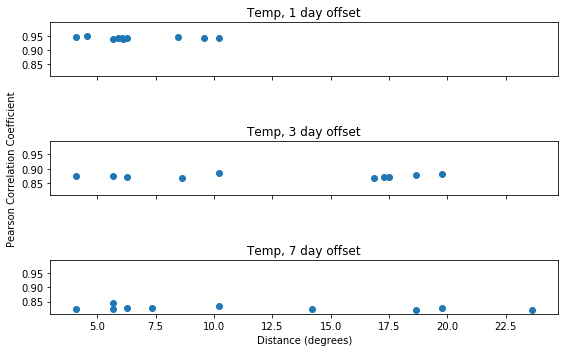

In [22]:
#here we plot the correlation in temperature between the top 10 pairs
#as a function of TOTAL distance between the pair

fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex = True, sharey = True, figsize = (8,5))

ax1.scatter(dists_1, temp_1_corrs)
ax1.set_title('Temp, 1 day offset')
ax2.scatter(dists_3, temp_3_corrs)
ax2.set_ylabel('Pearson Correlation Coefficient')
ax2.set_title('Temp, 3 day offset')
ax3.scatter(dists_7, temp_7_corrs)
ax3.set_xlabel('Distance (degrees)')
ax3.set_title('Temp, 7 day offset')
fig.tight_layout()
fig.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


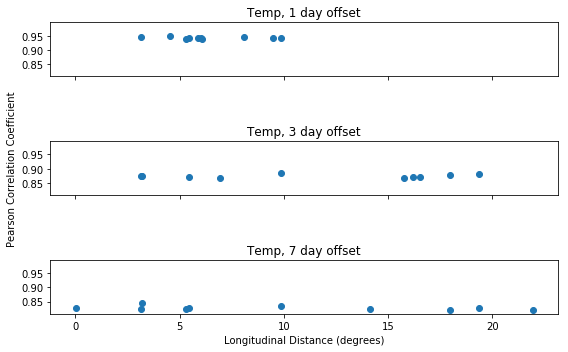

In [23]:
#here we plot the correlation in temperature between the top 10 pairs
#as a function of LONGITUDINAL distance between the pair

fig1, (ax10, ax20, ax30) = plt.subplots(3,1, sharex = True, sharey = True, figsize = (8,5))

ax10.scatter(dists_long_1, temp_1_corrs)
ax10.set_title('Temp, 1 day offset')
ax20.scatter(dists_long_3, temp_3_corrs)
ax20.set_ylabel('Pearson Correlation Coefficient')
ax20.set_title('Temp, 3 day offset')
ax30.scatter(dists_long_7, temp_7_corrs)
ax30.set_xlabel('Longitudinal Distance (degrees)')
ax30.set_title('Temp, 7 day offset')
fig1.tight_layout()
fig1.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


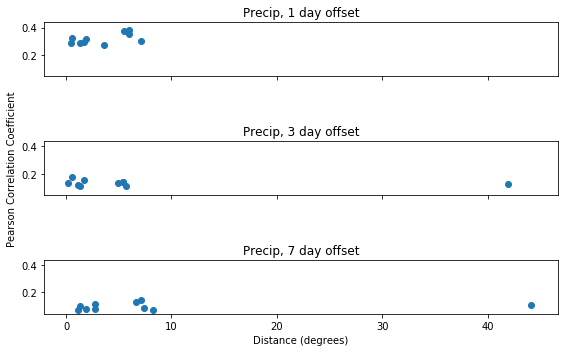

In [24]:
#here we plot the correlation in precipitation between the top 10 pairs
#as a function of TOTAL distance between the pair

fig2, (ax11, ax21, ax31) = plt.subplots(3,1, sharex = True, sharey = True, figsize = (8,5))

ax11.scatter(dist_1, precip_1_corrs)
ax11.set_title('Precip, 1 day offset')
ax21.scatter(dist_3, precip_3_corrs)
ax21.set_ylabel('Pearson Correlation Coefficient')
ax21.set_title('Precip, 3 day offset')
ax31.scatter(dist_7, precip_7_corrs)
ax31.set_xlabel('Distance (degrees)')
ax31.set_title('Precip, 7 day offset')
fig2.tight_layout()
fig2.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


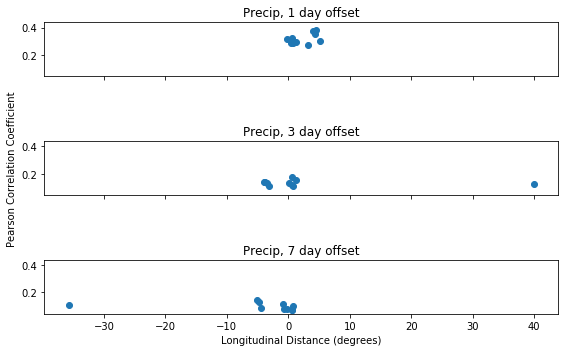

In [25]:
#here we plot the correlation in temperature between the top 10 pairs
#as a function of LONGITUDINAL distance between the pair

fig3, (ax12, ax22, ax32) = plt.subplots(3,1, sharex = True, sharey = True, figsize = (8,5))

ax12.scatter(dist_long_1, precip_1_corrs)
ax12.set_title('Precip, 1 day offset')
ax22.scatter(dist_long_3, precip_3_corrs)
ax22.set_ylabel('Pearson Correlation Coefficient')
ax22.set_title('Precip, 3 day offset')
ax32.scatter(dist_long_7, precip_7_corrs)
ax32.set_xlabel('Longitudinal Distance (degrees)')
ax32.set_title('Precip, 7 day offset')
fig3.tight_layout()
fig3.show()